
# **Machine Learning** 

- **1:** Insurance Charges Prediction (Regression)  
- **2:** Crime Rate Prediction (SVM Classification + Regression Forecast)




## ✅ Requirements
- Write clean, well‑commented code.
- **1:** Train multiple regression models (Linear Regression, Random Forest, XGBoost), evaluate with **MSE & R²**.  
- **2:** Preprocess crimes data, **SVM classification** for crime‑prone areas and **Regression** for trend forecasting, and show visualizations including **missing‑data impact**.
-**Streamlit** deploy.



## 🔗 Datasets (Kaggle)
- Insurance charges: https://www.kaggle.com/datasets/thedevastator/prediction-of-insurance-charges-using-age-gender  
- Indian crimes: https://www.kaggle.com/datasets/sudhanvahg/indian-crimes-dataset



In [34]:

import os, math, warnings, sys
import numpy as np
import pandas as pd
from pathlib import Path

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def describe_df(df, name="DataFrame"):
    print(f"\n{name}: shape={df.shape}")
    print(df.head(3))
    print("\nMissing values per column:")
    print(df.isna().sum().sort_values(ascending=False).head(20))



# 🧩  Insurance Charges Prediction (Regression)

**Goal:** Predict insurance charges based on age, BMI, children, sex, smoker, region.  
**Models:** LinearRegression, RandomForestRegressor, XGBRegressor (if installed).  
**Metrics:** MSE and R².

### 📂 Run Order – Insurance
1) Set `INSURANCE_CSV` path  
2) Load & EDA  
3) Preprocess & Split  
4) Train multiple models  
5) Compare & visualize


In [35]:

# 1) Set your CSV path. If you downloaded with Kaggle CLI, this likely is inside 'data/insurance/insurance.csv'
INSURANCE_CSV = "data/insurance.csv"  # <-- change if needed

# If file not found, fall back to prompting the user
if not Path(INSURANCE_CSV).exists():
    print("NOTE: Update INSURANCE_CSV to your local path. Example: 'insurance.csv'")


In [36]:

# 2) Load & EDA
import pandas as pd

try:
    ins = pd.read_csv(INSURANCE_CSV)
except Exception as e:
    print("Could not read CSV at:", INSURANCE_CSV, "| Error:", e)
    ins = pd.DataFrame()

if not ins.empty:
    describe_df(ins, "Insurance")
    # Quick numeric summary
    display(ins.describe(include='all').T.head(15))



Insurance: shape=(1338, 8)
   index  age     sex    bmi  children smoker     region     charges
0      0   19  female  27.90         0    yes  southwest  16884.9240
1      1   18    male  33.77         1     no  southeast   1725.5523
2      2   28    male  33.00         3     no  southeast   4449.4620

Missing values per column:
index       0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,1338.0,NaN,NaN,NaN,668.5,386.391641,0.0,334.25,668.5,1002.75,1337.0
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [37]:
# 3) Preprocess & Split  —— PLACE THIS BEFORE TRAINING!
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

assert not ins.empty, "Load the CSV first."

target = "charges"
X = ins.drop(columns=[target]).copy()
y = ins[target].copy()

# 🔧 Drop junk columns that sneak in from CSVs
junk_like = {"index", "unnamed: 0", "unnamed: 1", "unnamed: 0.1"}
drop_cols = [c for c in X.columns if c.strip().lower() in junk_like]
if drop_cols:
    print("Dropping junk columns:", drop_cols)
    X = X.drop(columns=drop_cols)

# Optional sanity check
print("Training on columns:", list(X.columns))

# Identify categorical & numeric
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Dropping junk columns: ['index']
Training on columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
Train/Test shapes: (1070, 6) (268, 6)


In [38]:

# 4) Train multiple models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

results = []

def eval_reg(model_name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    mse = mean_squared_error(yte, pred)
    r2 = r2_score(yte, pred)
    results.append({"model": model_name, "MSE": mse, "R2": r2})
    print(f"{model_name:>20} | MSE={mse:.2f}  R2={r2:.4f}")
    return model, pred

if not ins.empty:
    pipe_lr = Pipeline([("pre", pre), ("est", LinearRegression())])
    pipe_rf = Pipeline([("pre", pre), ("est", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))])

    print("Training models...")
    m_lr, pred_lr = eval_reg("LinearRegression", pipe_lr, X_train, X_test, y_train, y_test)
    m_rf, pred_rf = eval_reg("RandomForest",    pipe_rf, X_train, X_test, y_train, y_test)

    # Try XGBoost if available
    try:
        from xgboost import XGBRegressor
        pipe_xgb = Pipeline([("pre", pre), ("est", XGBRegressor(n_estimators=600, max_depth=5, learning_rate=0.05,
                                                                subsample=0.9, colsample_bytree=0.8,
                                                                random_state=RANDOM_STATE, n_jobs=-1))])
        m_xgb, pred_xgb = eval_reg("XGBRegressor", pipe_xgb, X_train, X_test, y_train, y_test)
    except Exception as e:
        print("XGBoost not installed or failed to import. Skipping XGB. Error:", e)


Training models...
    LinearRegression | MSE=33596915.85  R2=0.7836
        RandomForest | MSE=21287797.30  R2=0.8629
        XGBRegressor | MSE=22667683.95  R2=0.8540


,model,MSE,R2
1,RandomForest,2.128780e+07,0.862879
2,XGBRegressor,2.266768e+07,0.853991
0,LinearRegression,3.359692e+07,0.783593


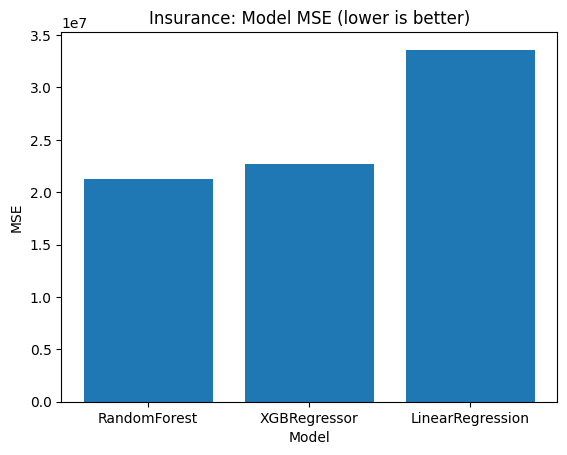

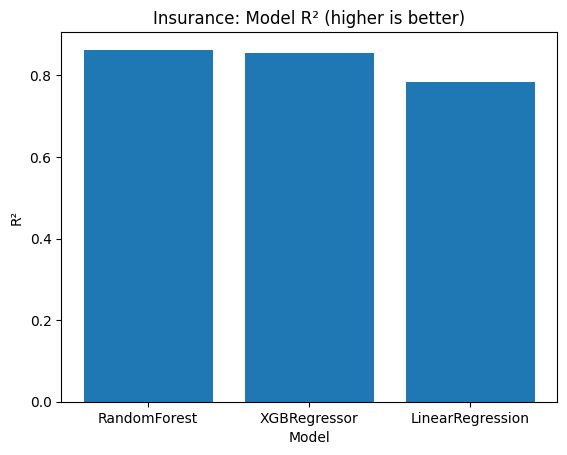

In [39]:

# 5) Compare & visualize results
import pandas as pd
import matplotlib.pyplot as plt

if results:
    df_res = pd.DataFrame(results).sort_values("MSE")
    display(df_res)

    # MSE bar
    plt.figure()
    plt.bar(df_res["model"], df_res["MSE"])
    plt.title("Insurance: Model MSE (lower is better)")
    plt.xlabel("Model")
    plt.ylabel("MSE")
    plt.show()

    # R2 bar
    plt.figure()
    plt.bar(df_res["model"], df_res["R2"])
    plt.title("Insurance: Model R² (higher is better)")
    plt.xlabel("Model")
    plt.ylabel("R²")
    plt.show()


In [40]:
# 6 Pick the best by lowest MSE and save it
import os, joblib
os.makedirs("models", exist_ok=True)

best = min(results, key=lambda r: r["MSE"])
best_name = best["model"]
print("Best by MSE:", best_name)

name_to_model = {"LinearRegression": m_lr, "RandomForest": m_rf}
try: name_to_model["XGBRegressor"] = m_xgb
except NameError: pass

best_model = name_to_model[best_name]
joblib.dump(best_model, "models/insurance_best.joblib")
print("Saved: models/insurance_best.joblib")


Best by MSE: RandomForest
Saved: models/insurance_best.joblib



### 🚀(Streamlit quick start)
Create a `streamlit_app.py` 

```python
import streamlit as st
import pandas as pd
import joblib
from pathlib import Path

st.title("Insurance Charges Predictor")

MODEL_PATH = Path("models/insurance_best.joblib")

# Load trained pipeline (preprocessing + model)
model = None
if MODEL_PATH.exists():
    model = joblib.load(MODEL_PATH)
else:
    st.warning("Model file not found. Train and save the model first (see notebook).")

# --- UI inputs ---
age = st.number_input("Age", min_value=18, max_value=100, value=30)
sex = st.selectbox("Sex", ["male", "female"])
bmi = st.number_input("BMI", min_value=10.0, max_value=60.0, value=25.01, step=0.01, format="%.2f")
children = st.number_input("Children", min_value=0, max_value=5, value=1)
smoker = st.selectbox("Smoker", ["yes", "no"])
region = st.selectbox("Region", ["southwest","southeast","northwest","northeast"])

X = pd.DataFrame([{
    "age": age,
    "sex": sex,
    "bmi": bmi,
    "children": children,
    "smoker": smoker,
    "region": region
}])

st.subheader("Your input")
st.write(X)

if model is None:
    st.stop()

if st.button("Predict charges"):
    try:
        y_pred = model.predict(X)[0]
        st.success(f"Estimated Charges: **${y_pred:,.2f}**")
    except Exception as e:
        st.error(f"Prediction failed: {e}")


```

Run: `streamlit run streamlit_app.py`



# 🧩 Crime Rate Prediction (SVM + Regression)

**Goal:**  
1) **Classification** — Label regions as *crime‑prone* (top quartile) vs others and train an **SVM**.  
2) **Forecasting** — Aggregate crimes by time (e.g., year or month) and fit a **regression** model to predict totals.  
3) **Visualize** missing‑data impact and trends.

>  Columns vary by dataset version. The code  it searches for common column names.


In [58]:

# 1) Set your crimes CSV path — adjust to your extracted file location.
# Commonly something like 'data/crime/indian_crimes.csv' or similar.
CRIME_CSV = "data/indian_crimes.csv"  # set your actual path
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path


Load & Column Normalization

Purpose: consistent lowercase snake_case names.

In [59]:
crime = pd.read_csv(CRIME_CSV)
crime.columns = [c.strip().lower().replace(" ", "_") for c in crime.columns]
print("Columns:", list(crime.columns)[:20])
crime.head(3)


Columns: ['report_number', 'date_reported', 'date_of_occurrence', 'time_of_occurrence', 'city', 'crime_code', 'crime_description', 'victim_age', 'victim_gender', 'weapon_used', 'crime_domain', 'police_deployed', 'case_closed', 'date_case_closed']


,report_number,date_reported,date_of_occurrence,time_of_occurrence,city,crime_code,crime_description,victim_age,victim_gender,weapon_used,crime_domain,police_deployed,case_closed,date_case_closed
0,1,02-01-2020 00:00,01-01-2020 00:00,01-01-2020 01:11,Ahmedabad,576,IDENTITY THEFT,16,M,Blunt Object,Violent Crime,13,No,NaN
1,2,01-01-2020 19:00,01-01-2020 01:00,01-01-2020 06:26,Chennai,128,HOMICIDE,37,M,Poison,Other Crime,9,No,NaN
2,3,02-01-2020 05:00,01-01-2020 02:00,01-01-2020 14:30,Ludhiana,271,KIDNAPPING,48,F,Blunt Object,Other Crime,15,No,NaN


Time Parsing → year, month

Purpose: avoid the fake year_idx fallback. Parse dates to real year/month.

In [60]:
# Pick a usable date column present in your file:
date_cols_try = ["date_reported","date_of_occurrence","date_case_closed"]
dt = None
for c in date_cols_try:
    if c in crime.columns:
        dt = pd.to_datetime(crime[c], dayfirst=True, errors="coerce")
        if dt.notna().any(): 
            break

assert dt is not None, "No parseable date column found. Check CSV."

crime["year"]  = dt.dt.year
crime["month"] = dt.dt.month
crime = crime[crime["year"].notna()]  # drop rows with no year
crime["year"] = crime["year"].astype(int)


Missing-Data Impact (Before)

Purpose: required visual per brief.

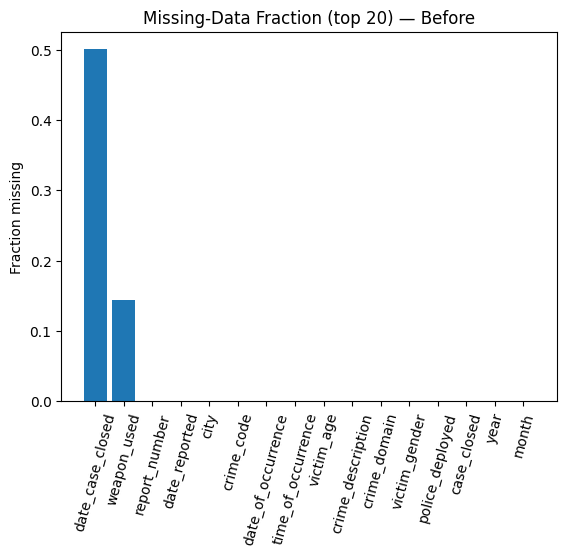

In [61]:
miss = crime.isna().mean().sort_values(ascending=False).head(20)
plt.figure(); plt.bar(miss.index.astype(str), miss.values)
plt.title("Missing-Data Fraction (top 20) — Before"); plt.xticks(rotation=75); plt.ylabel("Fraction missing"); plt.show()


Closed-date indicator & drop raw

In [62]:
# Build a robust indicator then drop the raw date column
if "date_case_closed" in crime.columns:
    crime["closed_has_date"] = crime["date_case_closed"].notna().astype(int)
    # Keep it for modeling/EDA; drop the raw string date to avoid dominating "missing" chart
    crime = crime.drop(columns=["date_case_closed"])


Clean & Normalize Categories

Purpose: tidy booleans/text, impute light gaps.

In [63]:
# Example normalizations (adapt to your columns)
if "case_closed" in crime.columns:
    crime["case_closed"] = crime["case_closed"].astype(str).str.strip().str.lower().map(
        {"yes":1, "no":0}
    ).fillna(0).astype(int)

for col in ["weapon_used","crime_domain","city","state","district"]:
    if col in crime.columns:
        crime[col] = crime[col].astype(str).str.strip().str.title().replace({"Nan":"Unknown"})

# Light imputations for numeric
num_cols = crime.select_dtypes(include=[float,int]).columns.tolist()
for c in num_cols:
    if crime[c].isna().any():
        crime[c] = crime[c].fillna(crime[c].median())


Features: totals & rate

Purpose: build total_crimes (row-level = 1, if each row is an incident) and crimes_per_100k if population exists.

In [64]:
# If each row is an incident, set 1 per row; otherwise sum numeric crime columns.
crime["incident"] = 1

# Per-100k if population column exists; else we’ll use raw counts.
pop_cols = [c for c in crime.columns if "pop" in c]


Classification Dataset Build(min_rows + extra feature)

Purpose: aggregate by region (city or district), compute crime rate, make top-quartile label.

In [65]:
region_key = "city" if "city" in crime.columns else ("district" if "district" in crime.columns else "state")

# Require at least N incidents per region so we don't classify on super-sparse groups
min_rows = 50
region_counts = crime[region_key].value_counts()
keep_regions = region_counts[region_counts >= min_rows].index
crime_cls = crime[crime[region_key].isin(keep_regions)].copy()

grp = crime_cls.groupby(region_key, as_index=False).agg(
    total_crimes=("incident","sum"),
    police_deployed=("police_deployed","median")
)

# crimes_per_100k if population exists; else proxy with total_crimes
pop_cols = [c for c in crime.columns if "pop" in c]
if pop_cols:
    pc = pop_cols[0]
    pop_by_region = crime_cls.groupby(region_key, as_index=False)[pc].median()
    grp = grp.merge(pop_by_region, on=region_key, how="left")
    grp["crimes_per_100k"] = (grp["total_crimes"] / grp[pc].replace({0:np.nan})) * 1e5
    grp["crimes_per_100k"] = grp["crimes_per_100k"].fillna(grp["crimes_per_100k"].median())
else:
    grp["crimes_per_100k"] = grp["total_crimes"]

# Top quartile label
th = grp["crimes_per_100k"].quantile(0.75)
grp["crime_prone"] = (grp["crimes_per_100k"] >= th).astype(int)

# Features: add police_deployed to stabilize SVM boundary
X = grp[["total_crimes","crimes_per_100k","police_deployed"]].fillna(grp.median(numeric_only=True))
y = grp["crime_prone"]


SVM Classification

Purpose: fit SVM on numeric summaries; show report + confusion matrix.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X = grp[["total_crimes","crimes_per_100k"]].copy()
y = grp["crime_prone"]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=2.0, gamma="scale", random_state=42))])
svm.fit(X_tr, y_tr)
pred = svm.predict(X_te)

print(classification_report(y_te, pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_te, pred))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         6
           1     1.0000    1.0000    1.0000         2

    accuracy                         1.0000         8
   macro avg     1.0000    1.0000    1.0000         8
weighted avg     1.0000    1.0000    1.0000         8

Confusion Matrix:
 [[6 0]
 [0 2]]


Trend Forecast (Monthly, clipped + smoothed)

Purpose: aggregate by year (from step 3), then train LR + RF, compare MSE/R², and plot Actual vs Pred.

LinearRegression  MSE=92.83  R²=0.5354
RandomForest      MSE=137.51  R²=0.3118


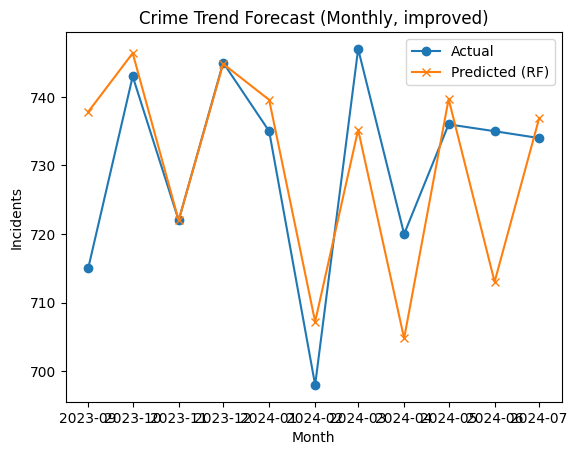

In [72]:
# Trend Forecast (Monthly, clipped + smoothed + rolling features)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# monthly aggregation
monthly = (crime.groupby(["year","month"], as_index=False)["incident"].sum()
                .sort_values(["year","month"]))
monthly["year_month"] = pd.to_datetime(dict(year=monthly["year"], month=monthly["month"], day=1))

# clip incomplete last month
median_val = monthly["incident"].median()
if len(monthly) > 6 and monthly.iloc[-1]["incident"] < 0.8 * median_val:
    monthly = monthly.iloc[:-1]

# add rolling mean & lag features
monthly["y"] = monthly["incident"]
monthly["y_roll3"] = monthly["y"].rolling(3, min_periods=1).mean()
monthly["y_lag1"] = monthly["y"].shift(1).fillna(method="bfill")

# temporal split
split = int(len(monthly)*0.8)
train, test = monthly.iloc[:split], monthly.iloc[split:]

# features: time + lag + rolling
trainX = pd.DataFrame({
    "time": train["year"] + train["month"]/12.0,
    "roll3": train["y_roll3"],
    "lag1": train["y_lag1"]
})
testX = pd.DataFrame({
    "time": test["year"] + test["month"]/12.0,
    "roll3": test["y_roll3"],
    "lag1": test["y_lag1"]
})

trainY, testY = train["y"], test["y"]

# models
lr = LinearRegression().fit(trainX, trainY)
rf = RandomForestRegressor(n_estimators=400, random_state=42).fit(trainX, trainY)

pred_lr = lr.predict(testX)
pred_rf = rf.predict(testX)

print(f"LinearRegression  MSE={mean_squared_error(testY,pred_lr):.2f}  R²={r2_score(testY,pred_lr):.4f}")
print(f"RandomForest      MSE={mean_squared_error(testY,pred_rf):.2f}  R²={r2_score(testY,pred_rf):.4f}")

# plot
plt.figure()
plt.plot(test["year_month"], testY, marker="o", label="Actual")
plt.plot(test["year_month"], pred_rf, marker="x", label="Predicted (RF)")
plt.title("Crime Trend Forecast (Monthly, improved)")
plt.xlabel("Month"); plt.ylabel("Incidents"); plt.legend(); plt.show()


Persist Models

Purpose: keep both models for a simple Streamlit demo.

In [73]:
import numpy as np, json, os, joblib

# attach feature names so inference won’t warn
rf.feature_names_in_ = np.array(trainX.columns, dtype=object)

os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/crime_trend_rf.joblib")

# also save the expected features for the app
with open("models/feature_columns_trend.json","w") as f:
    json.dump({"features_trend": ["time","roll3","lag1"]}, f)


In [74]:
import joblib, os
os.makedirs("models", exist_ok=True)
joblib.dump(svm, "models/crime_svm.joblib")
joblib.dump(rf,  "models/crime_trend_rf.joblib")


['models/crime_trend_rf.joblib']

Missing-Data Impact (After)

Purpose: show improvement post-cleaning.

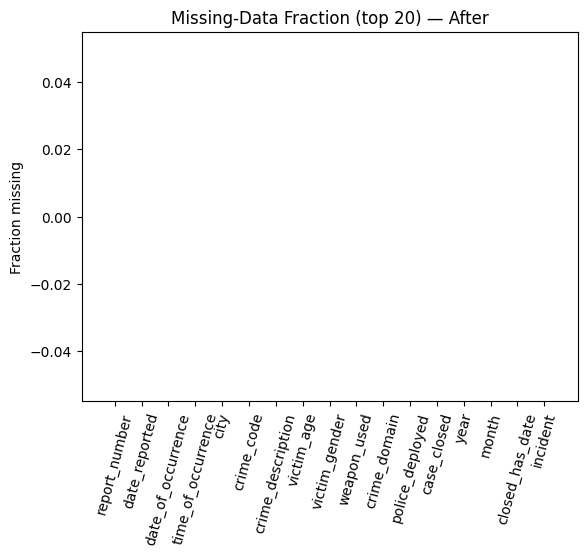

In [75]:
miss2 = crime.isna().mean().sort_values(ascending=False).head(20)
plt.figure(); plt.bar(miss2.index.astype(str), miss2.values)
plt.title("Missing-Data Fraction (top 20) — After"); plt.xticks(rotation=75); plt.ylabel("Fraction missing"); plt.show()



### 🚀(Streamlit quick start)
Create a `crime.py` 

```python
# crime.py

import streamlit as st
import pandas as pd
import numpy as np
import json, joblib
from pathlib import Path

st.title("Crime Analysis & Forecasting Dashboard")

# ---------- Load models ----------
svm_path  = Path("models/crime_svm.joblib")
rf_path   = Path("models/crime_trend_rf.joblib")
feat_path = Path("models/feature_columns_trend.json")  # optional metadata saved at training

svm = joblib.load(svm_path) if svm_path.exists() else None
rf  = joblib.load(rf_path)  if rf_path.exists()  else None

# Expected features for RF
expected_feats = None
if feat_path.exists():
    try:
        expected_feats = json.loads(feat_path.read_text()).get("features_trend")
    except Exception:
        pass
if expected_feats is None and rf is not None:
    exp = getattr(rf, "feature_names_in_", None)
    if exp is not None:
        expected_feats = list(exp)
if expected_feats is None and rf is not None:
    expected_feats = ["time"] if getattr(rf, "n_features_in_", 1) == 1 else ["time","roll3","lag1"]

# ---------- Tabs ----------
tab1, tab2 = st.tabs(["🔍 Crime-Prone Classification", "📈 Crime Trend Forecast"])

# ------------------ TAB 1: SVM ------------------
with tab1:
    st.header("Classify Region as Crime-Prone")
    total_crimes = st.number_input("Total Crimes", min_value=0, value=500)
    crimes_per_100k = st.number_input("Crimes per 100k", min_value=0.0, value=120.0, step=1.0)

    if st.button("Predict Crime-Prone"):
        if svm is None:
            st.error("SVM model not found. Train and save it first.")
        else:
            X = pd.DataFrame([{"total_crimes": total_crimes, "crimes_per_100k": crimes_per_100k}])
            pred = int(svm.predict(X)[0])
            st.success("⚠️ Crime-Prone Region" if pred==1 else "✅ Safer Region")

# ------------------ TAB 2: RF Trend ------------------
with tab2:
    st.header("Crime Trend Forecast (no upload needed)")

    # 1) Load monthly series or use demo
    data_path = Path("data/monthly_incidents.csv")
    if data_path.exists():
        df = pd.read_csv(data_path)
        if {"Month","Incidents"} - set(df.columns):
            st.error("data/monthly_incidents.csv must have columns: Month, Incidents"); st.stop()
        df["Month"] = pd.to_datetime(df["Month"])
        df["Incidents"] = pd.to_numeric(df["Incidents"], errors="coerce").fillna(0).astype(int)
    else:
        months = pd.date_range("2023-09", periods=12, freq="MS")
        incidents = [720, 745, 723, 749, 735, 698, 747, 720, 740, 715, 735, 732]
        df = pd.DataFrame({"Month": months, "Incidents": incidents})

    st.line_chart(df.set_index("Month"))

    # 2) Forecast button
    if st.button("Forecast"):
        if rf is None:
            st.error("Regression model not found. Train and save it first."); st.stop()

        # Build features to MATCH training
        df["time"]  = df["Month"].dt.year + df["Month"].dt.month/12.0
        df["roll3"] = df["Incidents"].rolling(3, min_periods=1).mean()
        df["lag1"]  = df["Incidents"].shift(1).bfill()  # no FutureWarning

        # Map model feature names -> df columns
        name_map = {"y_roll3":"roll3", "y_lag1":"lag1"}
        model_cols = [ (c if c in df.columns else name_map.get(c, None)) for c in expected_feats ]
        if any(c is None for c in model_cols):
            st.error(f"Expected features {expected_feats} not found. Re-train or update mapping."); st.stop()

        X = df[model_cols].copy()

        try:
            df["Predicted"] = rf.predict(X)
        except Exception as e:
            st.error(f"Prediction failed: {e}"); st.stop()

        st.line_chart(df.set_index("Month")[["Incidents","Predicted"]])
        st.success(f"Forecast OK · Used features: {model_cols}")




```

Run: `streamlit run crime.py`
